In [223]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz

from IPython.display import Image

%matplotlib inline

In [224]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

In [225]:
print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)
print("x_test.shape", x_test.shape)
print("y_test.shape", y_test.shape)

x_train.shape (200, 2)
y_train.shape (200, 1)
x_test.shape (800, 2)
y_test.shape (800, 1)


# 5. [Optional] Decision Tree Implementation

In this problem we'll implement decision trees for both classification
and regression. The strategy will be to implement a generic class,
called Decision\_Tree, which we'll supply with the loss function we
want to use to make node splitting decisions, as well as the estimator
we'll use to come up with the prediction associated with each leaf
node. For classification, this prediction could be a vector of probabilities,
but for simplicity we'll just consider hard classifications here.
We'll work with the classification and regression data sets from Homework
\#4. 

1.[Optional] Complete the class Decision\_Tree, given in the skeleton
code. The intended implementation is as follows: Each object of type
Decision\_Tree represents a single node of the tree. The depth of
that node is represented by the variable self.depth, with the root
node having depth 0. The main job of the fit function is to decide,
given the data provided, how to split the node or whether it should
remain a leaf node. If the node will split, then the splitting feature
and splitting value are recorded, and the left and right subtrees
are fit on the relevant portions of the data. Thus tree-building is
a recursive procedure. We should have as many Decision\_Tree objects
as there are nodes in the tree. We will not implement pruning here. Some additional details are given in the skeleton code.

#### Decision Tree Class

In [226]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method for splitting node
        :param leaf_value_estimator: method for estimating leaf value
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
       
        #if leaf, the two attributes below need to be set
        self.is_leaf = None
        self.value = None
        
        #if not leaf, the two attributes below need to be set
        self.split_id = None
        self.split_value = None
        
        #left and right subtrees
        self.left = None
        self.right = None
        


    def fit(self, X, y=None):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want to split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        
        #if depth==max_depth or number of samples < min_sample, this is a leaf
        if (self.depth == self.max_depth) or (X.shape[0] <=self.min_sample) :
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        
        #is not a leaf
        else:
            self.is_leaf = False
            
            num_features = 1 if len(X.shape)==1 else X.shape[1]
            
            best_splitter = None
            best_split_point = None
            min_loss = np.inf
            
            X_and_y = X.copy()
            X_and_y = np.column_stack((X_and_y, y))
            
            for i in range(num_features):
                X_and_y = X_and_y[X_and_y[:,i].argsort()] #sort by current feature
                
                for j in range(len(X_and_y)-1):
                    split_point = (X_and_y[j][i] + X_and_y[j+1][i])/2 
                    left_xs = X_and_y[:j+1,:-1].copy()
                    left_ys = X_and_y[:j+1,-1].copy()
                    
                    right_ys = X_and_y[j+1:,-1].copy()
                    right_xs = X_and_y[j+1:,:-1].copy()
                    left_loss = len(left_ys) * self.split_loss_function(left_ys)
                    right_loss = len(right_ys) * self.split_loss_function(right_ys)
                    if (left_loss+right_loss) < min_loss:
                        min_loss = left_loss + right_loss
                        best_splitter = i
                        best_split_point = split_point
                        best_left_ys = left_ys.reshape((left_ys.shape[0],1))
                        best_right_ys = right_ys.reshape((right_ys.shape[0],1))
                        best_left_xs = left_xs
                        best_right_xs = right_xs
                        
            self.split_id = best_splitter
            self.split_value = best_split_point
            
                        
            self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, \
                 self.depth+1, self.min_sample, self.max_depth)
            self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, \
                 self.depth+1, self.min_sample, self.max_depth)

            
            self.left.fit(best_left_xs, best_left_ys)
            self.right.fit(best_right_xs, best_right_ys)
           
        return self

    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

2.[Optional] Complete either the compute\_entropy or compute\_gini
functions. Run the code provided that builds trees for the two-dimensional
classification data. Include the results. For debugging, you may want
to compare results with sklearn's decision tree. For visualization,
you'll need to install graphviz.

#### Decision Tree Classifier

In [227]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return entropy: entropy value
    '''
    labels = np.unique(label_array)
    
    entropy = 0
    for label in labels:
        prob = np.sum(label==label_array)/len(label_array)
        ent += -(prob * np.log(prob))
    
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    
    labels = np.unique(label_array)
    
    gini = 1
    for label in labels:
        prob = np.sum(label==label_array)/len(label_array)
        gini -= prob**2
    
    return gini

In [228]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [229]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='gini', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

#### Decision Tree Boundary

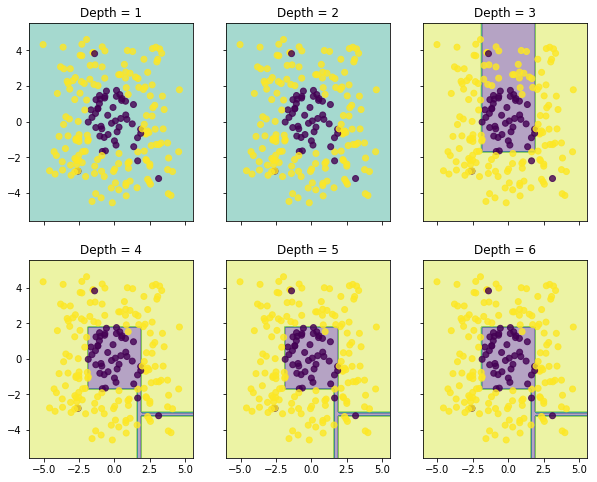

In [230]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

#### Compare decision tree with tree model in sklearn

In [231]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=5)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

In [232]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png

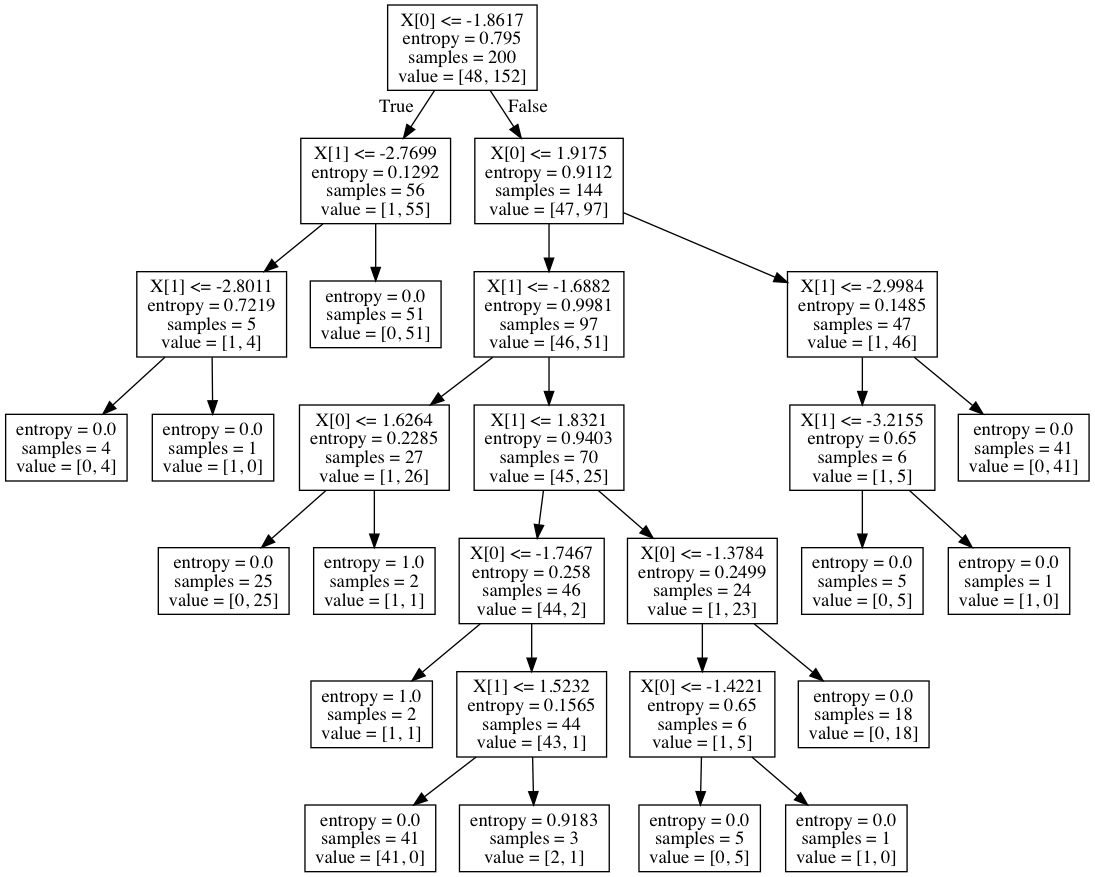

In [233]:
Image(filename='tree_classifier.png')

3.[Optional] Complete the function mean\_absolute\_deviation\_around\_median
(MAE). Use the code provided to fit the Regression\_Tree to the krr
dataset using both the MAE loss and median predictions. Include the
plots for the 6 fits.

#### Decision Tree Regressor

In [234]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    median = np.median(y)
    abs_sums = np.abs(median-y)
    mae = np.mean(abs_sums)
        
    return mae

In [235]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

#### Fit regression tree to one-dimensional regression data

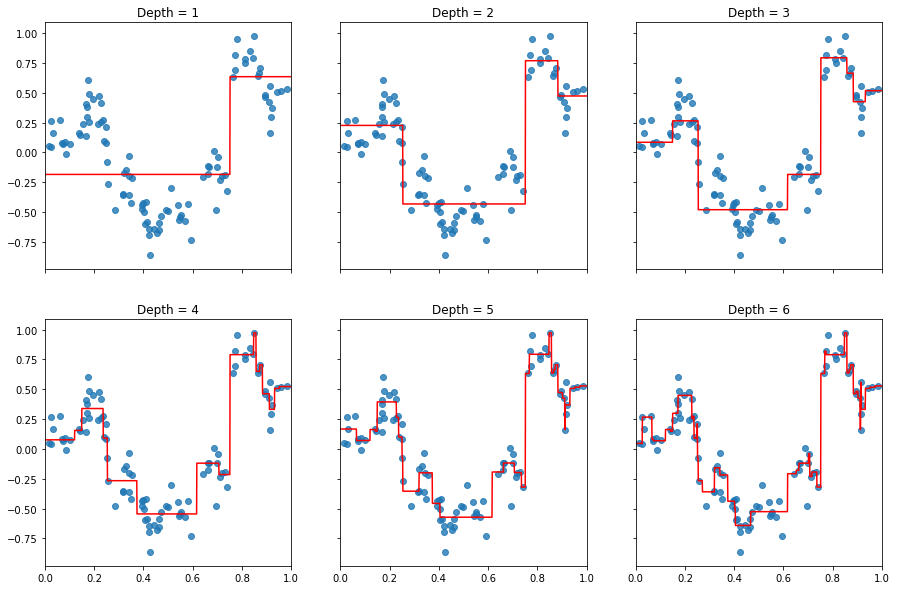

In [236]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=1, loss_function='mae', estimator='median')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=1, loss_function='mae', estimator='median')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=1, loss_function='mae', estimator='median')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=1, loss_function='mae', estimator='median')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=1, loss_function='mae', estimator='median')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=6,  min_sample=1, loss_function='mae', estimator='median')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# 6. Gradient Boosting Implementation

This method goes by many names, including gradient boosting machines
(GBM), generalized boosting models (GBM), AnyBoost, and gradient boosted
regression trees (GBRT), among others. Although one of the nice aspects
of gradient boosting is that it can be applied to any problem with
a subdifferentiable loss function, here we'll keep things simple and
consider the standard regression setting with square loss. 

1.Complete the gradient\_boosting class. As the base regression algorithm,
you should use the regression tree from the previous problem, if you
completed it. Otherwise, you may use sklearn's regression tree. You
should use the square loss for the tree splitting rule and the mean
function for the leaf prediction rule. Run the code provided to build
gradient boosting models on the classification and regression data
sets, and include the plots generated. Note that we are using square
loss to fit the classification data, as well as the regression data.

#### Gradient Boosting Method

In [237]:
#Pseudo-residual function.
#Here you can assume that we are using L2 loss

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [238]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.1, min_sample=5, max_depth=3):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth
        
        self.weak_predictors = None
        self.sum_preds_so_far = None
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        '''
        
        self.weak_predictors = []
        f0 = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_sample)
        f0.fit(train_data, np.zeros(len(train_target)))
        self.weak_predictors.append(f0)

        
        for i in range(self.n_estimator+1):
            
            
            this_preds = np.zeros(len(train_data))
            
            for  predictor in self.weak_predictors:
                this_preds += self.learning_rate * predictor.predict(train_data)
    
            this_rm = self.pseudo_residual_func(train_target.reshape(-1), this_preds)
            hm = DecisionTreeRegressor(max_depth=self.max_depth,  min_samples_leaf=self.min_sample)
            
            hm.fit(train_data, this_rm)
            self.weak_predictors.append(hm)
                                       
            
    
    def predict(self, test_data):
        '''
        Predict value
        '''
        preds = np.zeros(len(test_data))
        
        for predictor in self.weak_predictors:
            preds += self.learning_rate * predictor.predict(test_data)

        return preds
        
#second impl

#### 2-D GBM visualization - SVM data

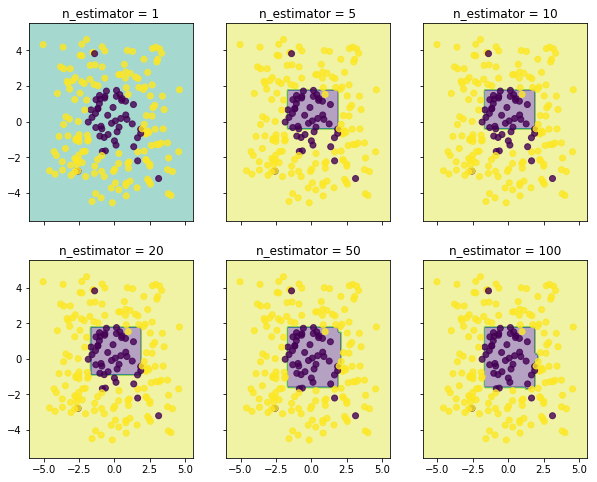

In [239]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbt = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbt.fit(x_train, y_train)
                   
    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

#### 1-D GBM visualization - KRR data

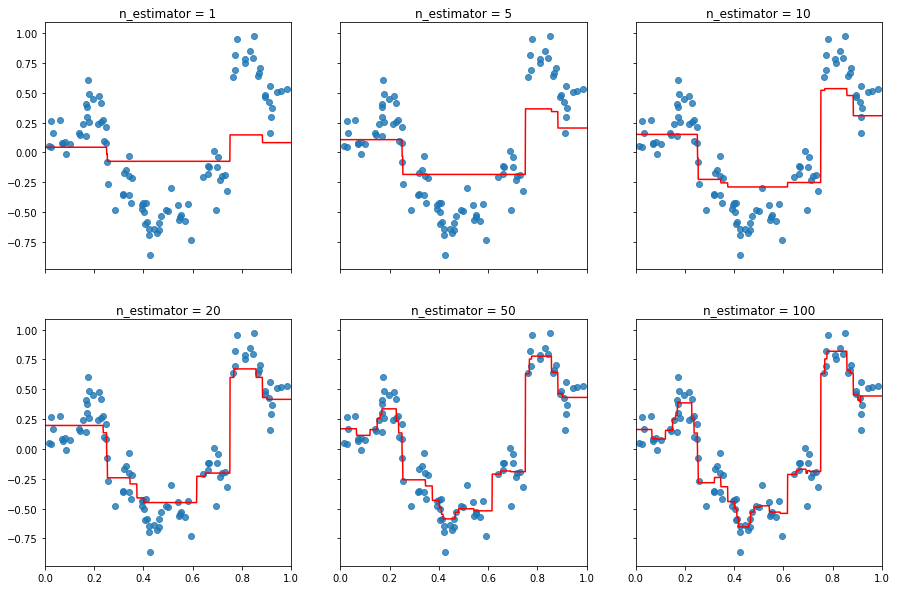

In [244]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbm_1d.fit(x_krr_train, y_krr_train)
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

2.[Optional] Repeat the previous runs on the classification data
set, but use a different classification loss, such as logistic loss
or hinge loss. Include the new code and plots of your results. Note
that you should still use the same regression tree settings for the
base regression algorithm. 

#### Logisitic loss

$l\left(y, f(x)\right) = ln(1+e^{-y f(x)})$

$r = \frac{e^{-y f(x)}.y}{(1+e^{-y f(x)}).ln(e)}$
$ = \frac{e^{-y f(x)}.y}{(1+e^{-y f(x)})}$

In [240]:
def pseudo_residual_logistic(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    margin = train_target * train_predict #numpy broadcasting ensures element-wise multiplication
    return ((np.exp(-margin))*train_target)/(1+np.exp(-margin))

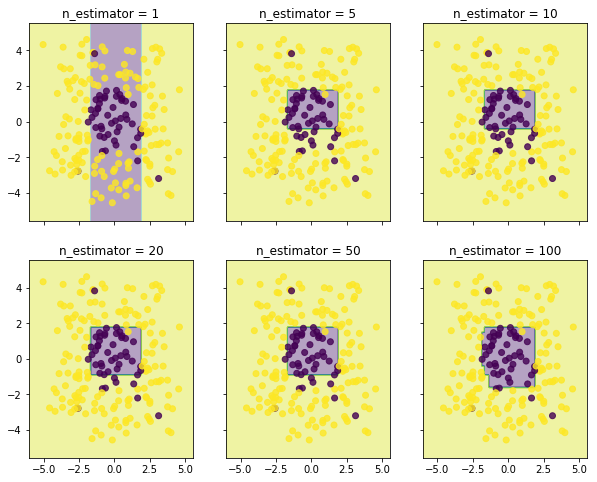

In [241]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbt = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_logistic, max_depth=2)  
    gbt.fit(x_train, y_train)
                   
    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

#### Exponential loss

$l\left(y, f(x)\right) = e^{-yf(x)}$

$r = e^{-y f(x)}.y$

In [242]:
def pseudo_residual_exp(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    margin = train_target * train_predict #numpy broadcasting ensures element-wise multiplication
    return (np.exp(-margin))*train_target

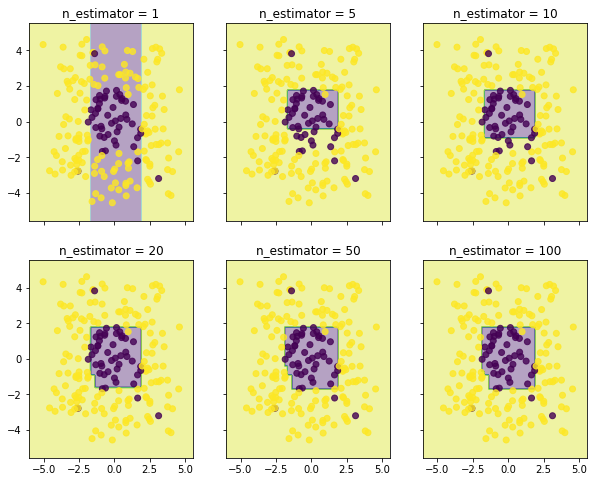

In [243]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbt = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_exp, max_depth=2)  
    gbt.fit(x_train, y_train)
                   
    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)